In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science'])
plt.rcParams.update({'font.size': 20, 'text.usetex': True})

## Part I: Sin vs Unf (Single Polynomial Unit)

We first compare the single polynomial unit $|p(\varphi)|^2$ for both amplitude distributions.

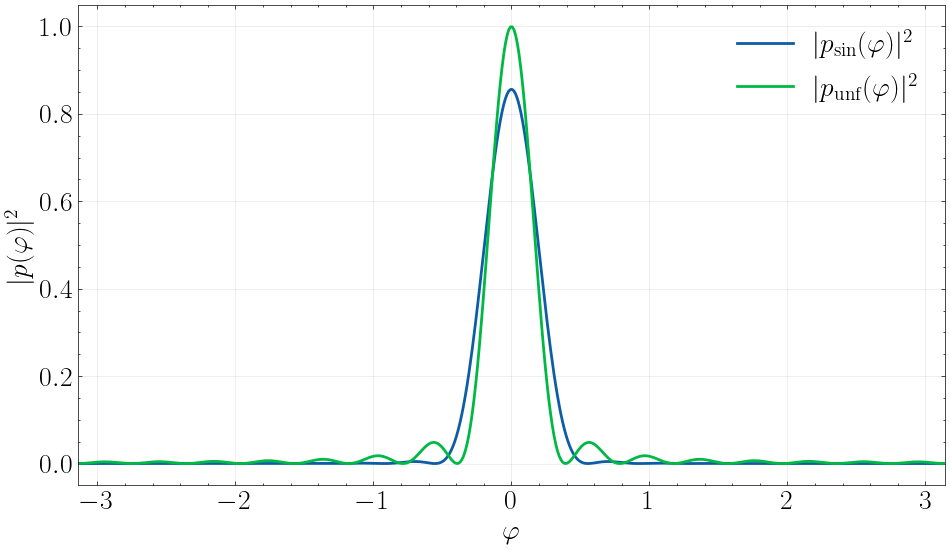

In [2]:
def poly_unit_sin(d, phi):
    """Single polynomial unit with sin coefficients."""
    p = np.zeros_like(phi, dtype=np.complex128)
    norm = np.sqrt(2.0 / (d * (d + 1)))
    for k in range(d):
        c_k = np.sin((k + 1) * np.pi / (d + 1))
        p += norm * c_k * np.exp(1j * k * phi)
    return np.abs(p)**2

def poly_unit_unf(d, phi):
    """Single polynomial unit with uniform coefficients."""
    p = np.zeros_like(phi, dtype=np.complex128)
    for k in range(d):
        p += np.exp(1j * k * phi)
    return np.abs(p / d)**2

# Compare for d=16
d = 16
phi = np.linspace(-np.pi, np.pi, 500)
P_sin = poly_unit_sin(d, phi)
P_unf = poly_unit_unf(d, phi)

plt.figure(figsize=(10, 6))
plt.plot(phi, P_sin, linewidth=2, label=r'$|p_{\sin}(\varphi)|^2$')
plt.plot(phi, P_unf, linewidth=2, label=r'$|p_{\mathrm{unf}}(\varphi)|^2$')
plt.xlabel(r'$\varphi$')
plt.ylabel(r'$|p(\varphi)|^2$')
plt.xlim(-np.pi, np.pi)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part II: Sin vs Unf (Binary Decision)

We now sum shifted polynomial units to create the binary decision polynomial $P_0(\varphi)$.

**Key observation**: Sin produces smoother transitions with better convergence, while unf creates sharper but more oscillatory tails. **We use only sin for the remainder of the analysis**.

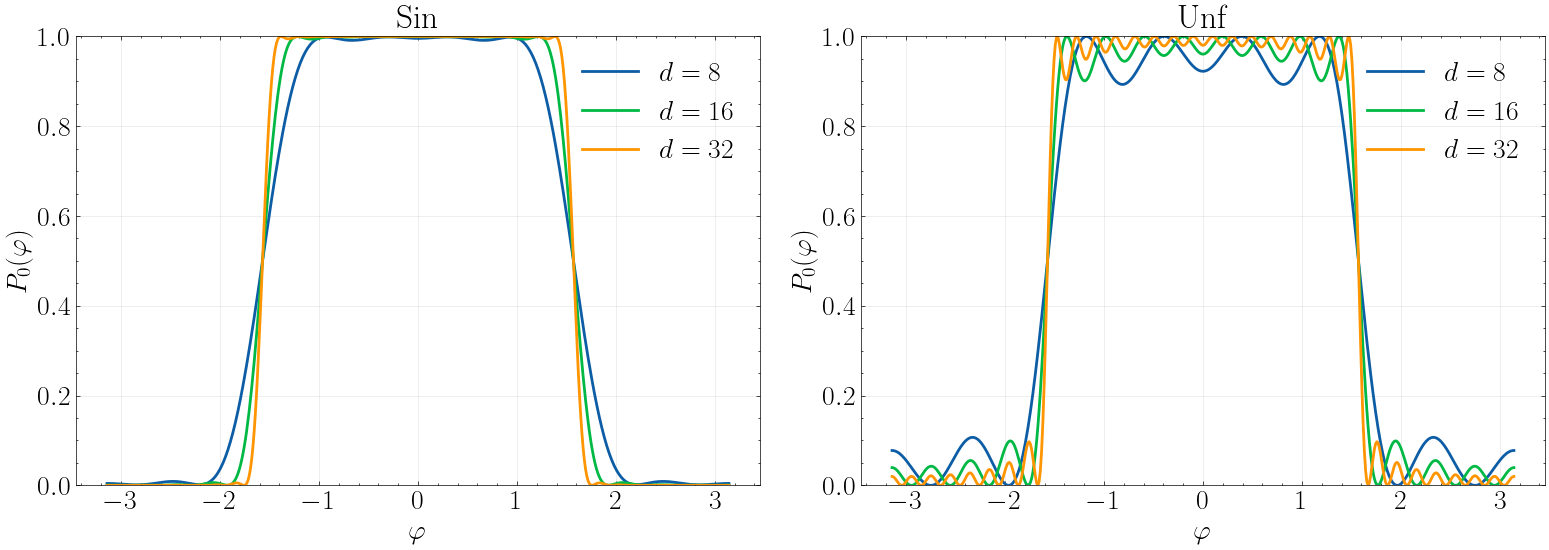

In [3]:
def binary_decision_sin(d, phi):
    """Binary decision polynomial with sin coefficients."""
    P = np.zeros_like(phi, dtype=np.float64)
    for j in range(d >> 1):
        phi_j = (j - (d/2 - 1) / 2) * 2 * np.pi / d
        P += poly_unit_sin(d, phi + phi_j)
    return P

def binary_decision_unf(d, phi):
    """Binary decision polynomial with uniform coefficients."""
    P = np.zeros_like(phi, dtype=np.float64)
    for j in range(d >> 1):
        phi_j = (j - (d/2 - 1) / 2) * 2 * np.pi / d
        P += poly_unit_unf(d, phi + phi_j)
    return P

# Compare summed polynomials
d_values = [8, 16, 32]
phi = np.linspace(-np.pi, np.pi, 500)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for d in d_values:
    P_sin = binary_decision_sin(d, phi)
    ax1.plot(phi, P_sin, linewidth=2, label=f'$d={d}$')

ax1.set_xlabel(r'$\varphi$')
ax1.set_ylabel(r'$P_0(\varphi)$')
ax1.set_title('Sin')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(True, alpha=0.3)

for d in d_values:
    P_unf = binary_decision_unf(d, phi)
    ax2.plot(phi, P_unf, linewidth=2, label=f'$d={d}$')

ax2.set_xlabel(r'$\varphi$')
ax2.set_ylabel(r'$P_0(\varphi)$')
ax2.set_title('Unf')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part III: Error Analysis (Sin Only)

We quantify approximation quality using two error measures:

1. **Max error** $\varepsilon_\delta$: Maximum deviation from the ideal step function in regions $[-\pi+\delta, -\delta]$ and $[\delta, \pi-\delta]$
2. **Average error** $P_e$: Mean absolute deviation over the entire domain

Both errors scale with degree $d$ for different gap sizes $\delta$.

d=   8: ε_{0.1}=0.9988, ε_{0.05}=0.9988, ε_{0.01}=0.9988, P_e=0.0656
d=  16: ε_{0.1}=0.9998, ε_{0.05}=0.9998, ε_{0.01}=0.9998, P_e=0.0353
d=  32: ε_{0.1}=1.0000, ε_{0.05}=1.0000, ε_{0.01}=1.0000, P_e=0.0184
d=  64: ε_{0.1}=1.0000, ε_{0.05}=1.0000, ε_{0.01}=1.0000, P_e=0.0094
d= 128: ε_{0.1}=1.0000, ε_{0.05}=1.0000, ε_{0.01}=1.0000, P_e=0.0048
d= 256: ε_{0.1}=1.0000, ε_{0.05}=1.0000, ε_{0.01}=1.0000, P_e=0.0024
d= 512: ε_{0.1}=1.0000, ε_{0.05}=1.0000, ε_{0.01}=1.0000, P_e=0.0012


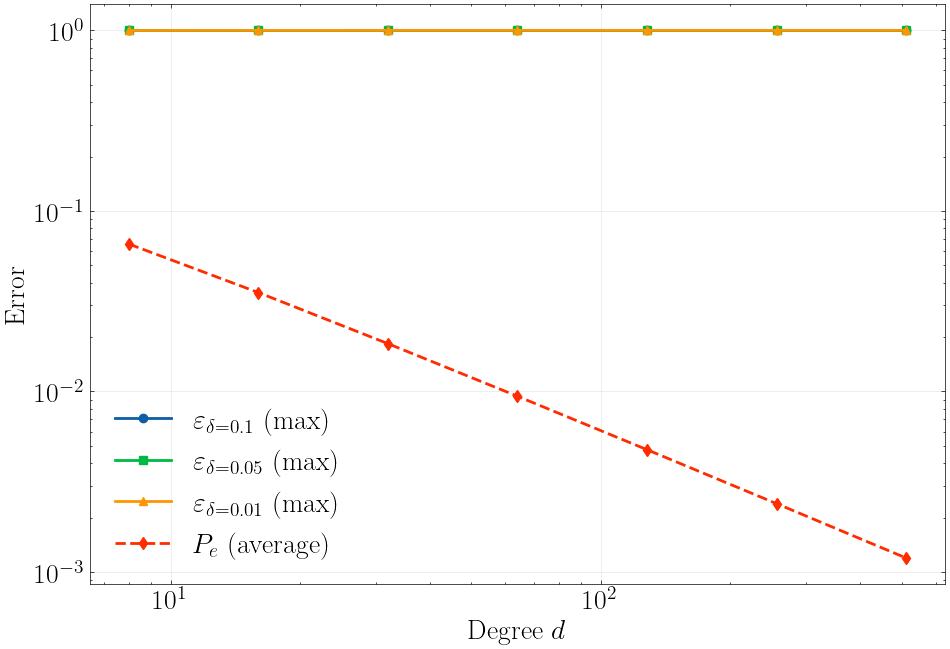

In [4]:
def compute_errors(d, delta_values, n_phi=2000):
    """Compute max and average errors for binary decision polynomial."""
    phi = np.linspace(-np.pi, np.pi, n_phi)
    P = binary_decision_sin(d, phi)
    
    # Max errors for each delta
    max_errors = []
    for delta in delta_values:
        # Left region: should be ~1
        mask_left = (phi >= -np.pi + delta) & (phi <= -delta)
        err_left = np.max(np.abs(P[mask_left] - 1.0))
        
        # Right region: should be ~0
        mask_right = (phi >= delta) & (phi <= np.pi - delta)
        err_right = np.max(P[mask_right])
        
        max_errors.append(max(err_left, err_right))
    
    # Average error
    target = np.where(np.abs(phi) < np.pi / 2, 1., 0.)
    avg_error = np.mean(np.abs(P - target))
    
    return max_errors, avg_error

# Compute errors for various degrees
d_values = [8, 16, 32, 64, 128, 256, 512]
delta_values = [0.1, 0.05, 0.01]

errors_max = {delta: [] for delta in delta_values}
errors_avg = []

for d in d_values:
    max_errs, avg_err = compute_errors(d, delta_values)
    for i, delta in enumerate(delta_values):
        errors_max[delta].append(max_errs[i])
    errors_avg.append(avg_err)
    print(f'd={d:4d}: ε_{{0.1}}={errors_max[0.1][-1]:.4f}, '
          f'ε_{{0.05}}={errors_max[0.05][-1]:.4f}, '
          f'ε_{{0.01}}={errors_max[0.01][-1]:.4f}, '
          f'P_e={errors_avg[-1]:.4f}')

# Plot all errors in one figure
plt.figure(figsize=(10, 7))
plt.plot(d_values, errors_max[0.1], marker='o', linewidth=2, label=r'$\varepsilon_{\delta=0.1}$ (max)')
plt.plot(d_values, errors_max[0.05], marker='s', linewidth=2, label=r'$\varepsilon_{\delta=0.05}$ (max)')
plt.plot(d_values, errors_max[0.01], marker='^', linewidth=2, label=r'$\varepsilon_{\delta=0.01}$ (max)')
plt.plot(d_values, errors_avg, marker='d', linewidth=2, linestyle='--', label=r'$P_e$ (average)')
plt.xlabel(r'Degree $d$')
plt.ylabel(r'Error')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part IV: Root Finding and Complex Square Root

We analyze the structure of $P_0(\varphi)$ through its Fourier representation and complex roots.

### Fourier Representation

The binary decision polynomial has a Fourier expansion:
$$P_0(\varphi) = \sum_{m=-(d-1)}^{d-1} \hat{P}_m e^{im\varphi}$$

where coefficients $\hat{P}_m$ are computed via convolution of the polynomial unit's Fourier modes.

### Complex Square Root via Roots

**Key theorem**: For any real Fourier series $P_0(\varphi)$ with $0 \le P_0(\varphi) \le 1$, there exists a polynomial $P(z)$ such that $P_0(\varphi) = |P(e^{i\varphi})|^2$.

**Construction idea**: 
1. View $P_0$ as a Laurent polynomial $Q(z) = z^d P_0(\varphi)$ where $z = e^{i\varphi}$
2. Observe that if $z_0$ is a root of $Q(z)$, then so is $1/z_0^*$ (conjugate reciprocal symmetry from reality of $P_0$)
3. Factor $Q(z)$ into pairs: each root $z_k$ pairs with $1/z_k^*$
4. Select roots with $|z_k| < 1$ (inside unit circle) to form $P(z) = \alpha \prod_{|z_k|<1} (z - z_k)$
5. The constant $\alpha$ is chosen so that $|P(e^{i\varphi})|^2 = P_0(\varphi)$ on the circle

This construction guarantees exactly $d-1$ roots inside the unit circle, yielding a degree-$(d-1)$ polynomial for QSP implementation.

In [5]:
def get_fourier_coeffs(d):
    """Fourier coefficients of polynomial unit with sin coefficients."""
    norm = np.sqrt(2.0 / (d * (d + 1)))
    return norm * np.array([np.sin((k + 1) * np.pi / (d + 1)) for k in range(d)], dtype=np.complex128)

def compute_P_fourier_coeffs(d, coeffs_p):
    """Fourier coefficients of P_0 via convolution and phase shifts."""
    # Fourier coeffs indexed from -(d-1) to +(d-1)
    P_coeffs = np.zeros(2*d - 1, dtype=np.complex128)
    
    for j in range(d >> 1):
        phi_j = (j - (d/2 - 1) / 2) * 2 * np.pi / d
        
        # Convolution for |p|^2 and phase shift
        for m in range(-(d-1), d):
            c_m = 0.0
            for k in range(d):
                if 0 <= k - m < d:
                    c_m += coeffs_p[k] * np.conj(coeffs_p[k - m])
            P_coeffs[m + (d-1)] += c_m * np.exp(1j * m * phi_j)
    
    return P_coeffs

# Compute Fourier representation
d = 16
coeffs_p = get_fourier_coeffs(d)
P_coeffs = compute_P_fourier_coeffs(d, coeffs_p)

print(f'Polynomial unit p: {d} Fourier modes (k = 0 to {d-1})')
print(f'Binary decision P_0: {len(P_coeffs)} Fourier modes (m = {-(d-1)} to {d-1})')
print(f'DC component P_0(0): {P_coeffs[d-1].real:.6f}')
print(f'Normalization: sum |c_k|^2 = {np.sum(np.abs(coeffs_p)**2):.6f}')

Polynomial unit p: 16 Fourier modes (k = 0 to 15)
Binary decision P_0: 31 Fourier modes (m = -15 to 15)
DC component P_0(0): 0.500000
Normalization: sum |c_k|^2 = 0.062500


Total roots: 30
Roots inside unit circle (|z| < 0.9999): 15
Roots outside unit circle (|z| ≥ 0.9999): 15


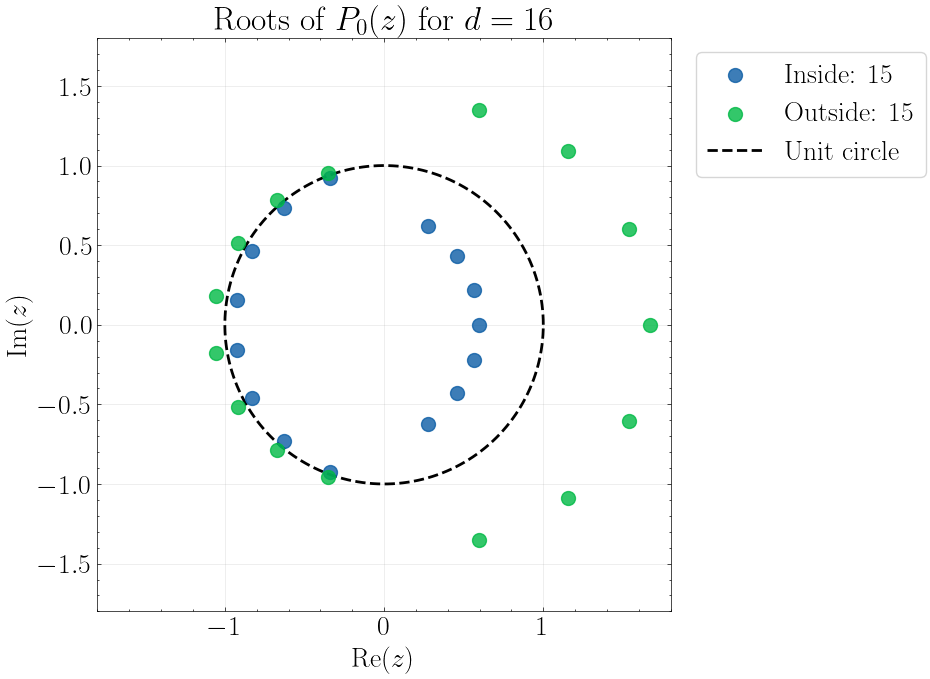

In [6]:
# Find roots of P_0 viewed as polynomial
roots = np.roots(P_coeffs[::-1])  # numpy.roots expects descending order

# Use stricter threshold to separate inside/outside
threshold = 0.9999
roots_inside = roots[np.abs(roots) < threshold]
roots_outside = roots[np.abs(roots) >= threshold]

print(f'Total roots: {len(roots)}')
print(f'Roots inside unit circle (|z| < {threshold}): {len(roots_inside)}')
print(f'Roots outside unit circle (|z| ≥ {threshold}): {len(roots_outside)}')

# Visualize roots
fig, ax = plt.subplots(figsize=(9, 8))
ax.scatter(roots_inside.real, roots_inside.imag, s=100, alpha=0.8, 
           color='C0', zorder=3, label=f'Inside: {len(roots_inside)}')
ax.scatter(roots_outside.real, roots_outside.imag, s=100, alpha=0.8, 
           color='C1', zorder=3, label=f'Outside: {len(roots_outside)}')

theta_circle = np.linspace(0, 2*np.pi, 200)
ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'k--', linewidth=2, 
        label='Unit circle', zorder=2)

ax.set_xlabel(r'Re$(z)$')
ax.set_ylabel(r'Im$(z)$')
ax.set_title(f'Roots of $P_0(z)$ for $d={d}$')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.8, 1.8)

# Place legend outside the plot area
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True)

plt.tight_layout()
plt.show()

In [7]:
# Construct p_1(z) from inside roots
p1_coeffs = np.poly(roots_inside)  # descending order
p1_fourier = p1_coeffs[::-1]  # ascending order for Fourier

print(f'Square root polynomial p_1: degree {len(p1_coeffs)-1}')

# Compute |p_1|^2 Fourier coefficients via convolution
deg = len(p1_fourier) - 1
p1_sq_coeffs = np.zeros(2*deg + 1, dtype=np.complex128)

for m in range(-deg, deg+1):
    for k in range(deg+1):
        if 0 <= k - m <= deg:
            p1_sq_coeffs[m + deg] += p1_fourier[k] * np.conj(p1_fourier[k - m])

# Scale to match P_0
dc_p1 = p1_sq_coeffs[deg]
dc_P = P_coeffs[d-1]
alpha = np.sqrt(dc_P / dc_p1)

print(f'Scaling factor = {np.abs(alpha):.6f}')

# Apply scaling
p1_coeffs_scaled = p1_coeffs * alpha
p1_sq_coeffs_scaled = p1_sq_coeffs * (alpha**2)

# Make sure p_1(1) > 0 by global phase adjustment
p1_coeffs_scaled *= np.exp(-1j * np.angle(np.sum(p1_coeffs_scaled)))
print(f'p_1(1) = {np.sum(p1_coeffs_scaled):.6f}')

print(f'DC match: |p_1|^2 = {p1_sq_coeffs_scaled[deg]:.6f}, P_0 = {dc_P:.6f}')


Square root polynomial p_1: degree 15
Scaling factor = 0.212257
p_1(1) = 0.999679-0.000000j
DC match: |p_1|^2 = 0.500000+0.000000j, P_0 = 0.500000+0.000000j


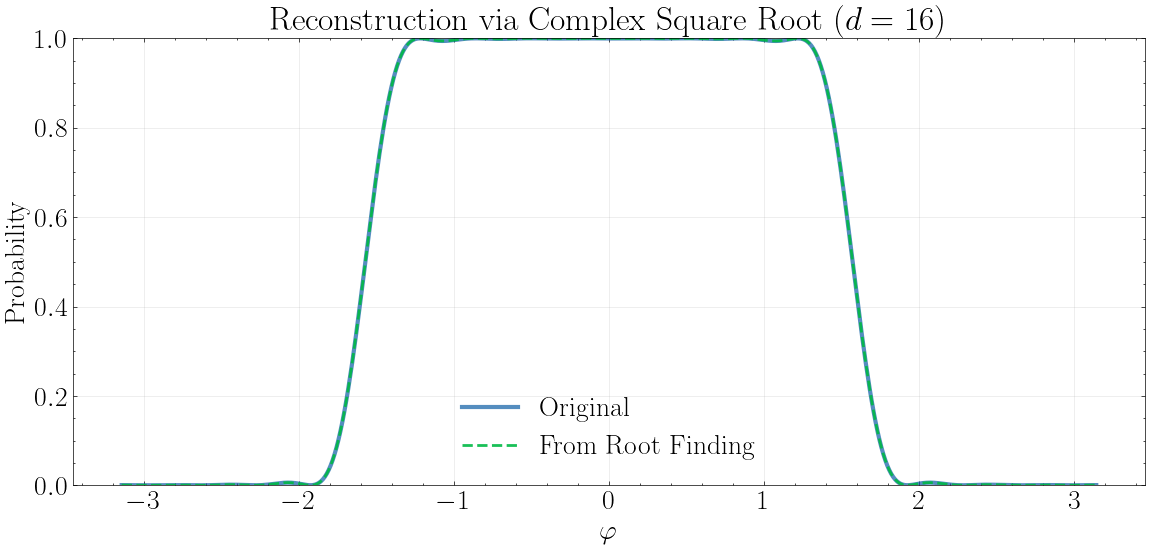

Max reconstruction error: 1.48e-14


In [8]:
# Verify on unit circle
n_points = 500
phi_test = np.linspace(-np.pi, np.pi, n_points)
z_test = np.exp(1j * phi_test)

# Evaluate p_1(z)
p1_vals = np.polyval(p1_coeffs_scaled, z_test)
p1_sq_direct = np.abs(p1_vals)**2

# Evaluate P_0 from Fourier
P_vals = np.zeros_like(phi_test, dtype=np.complex128)
for m in range(-(d-1), d):
    P_vals += P_coeffs[m + (d-1)] * np.exp(1j * m * phi_test)
P_vals = np.real(P_vals)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(phi_test, P_vals, linewidth=3, label=r'Original', alpha=0.7)
plt.plot(phi_test, p1_sq_direct, linewidth=2, linestyle='--', 
        label=r'From Root Finding', alpha=0.9)
plt.xlabel(r'$\varphi$')
plt.ylabel('Probability')
plt.title(f'Reconstruction via Complex Square Root ($d={d}$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print(f'Max reconstruction error: {np.max(np.abs(p1_sq_direct - P_vals)):.2e}')

## Part V: QSP Angle Optimization (GPU Accelerated)

In [9]:
import torch
# Check device availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name()}')

# Set default dtype
torch.set_default_dtype(torch.float64)
torch.set_default_device(device)
print(f'Default dtype: {torch.get_default_dtype()}')


Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Default dtype: torch.float64


### QSP Convention

We use the convention:

$$U_{\text{QSP}} = R_X(\theta_0)\, R_Z(\varphi)\, R_X(\theta_1)\, R_Z(\varphi)\, \cdots\, R_X(\theta_d)$$

where $R_X(\theta) = \begin{pmatrix}\cos\theta & -i\sin\theta \\ -i\sin\theta & \cos\theta\end{pmatrix}$ and $R_Z(\varphi) = \mathrm{diag}(e^{i\varphi}, 1)$.

The $d+1$ angles $\{\theta_k\}$ are optimized via LBFGS. The optimizer may need multiple restarts.

In [13]:
def qspOpt(targPoly, degQsp, samplePoints, max_iter=500, lr=1):
    """QSP: R_X(theta_0) @ R_Z(phi_0) @ R_X(theta_1) @ R_Z(phi_1) @ ... @ R_X(theta_d)"""
    z_samples = torch.exp(1j * samplePoints)
    target_vals = targPoly(z_samples)
    
    # Initialize theta parameters (d+1 R_X gates)
    theta_params = torch.nn.Parameter(
        torch.rand(degQsp + 1, dtype=torch.float64) * 2 * torch.pi
    )
    
    optimizer = torch.optim.LBFGS([theta_params], lr=lr, max_iter=20, history_size=10, line_search_fn='strong_wolfe')
    losses = []
    
    def closure():
        optimizer.zero_grad()
        
        # Initialize state vectors
        v0 = torch.ones_like (samplePoints, dtype=torch.complex128)
        v1 = torch.zeros_like(samplePoints, dtype=torch.complex128)

        # Apply QSP: R_X(theta_0) @ R_Z(phi_0) @ ... @ R_X(theta_d)
        for i in range(degQsp + 1):
            theta = theta_params[i]
            # R_X(theta) = [[cos(theta), -i*sin(theta)], [-i*sin(theta), cos(theta)]]
            cos_theta = torch.cos(theta)
            sin_theta = torch.sin(theta)
            # Correct R_X gate: |psi⟩ = cos(θ)|0⟩ - i*sin(θ)|1⟩
            v0_new = cos_theta * v0 - 1j * sin_theta * v1
            v1_new = -1j * sin_theta * v0 + cos_theta * v1
            v0, v1 = v0_new, v1_new
            
            # R_Z(phi) = diag(e^{i*phi}, 1), except after last R_X
            if i != degQsp:
                v0 *= z_samples
        
        # Loss
        err_vec = v0 - target_vals
        loss = torch.mean(torch.abs(err_vec)**2)
        loss.backward()
        losses.append(loss.item())
        return loss
    
    # Optimize
    for iteration in range(max_iter):
        optimizer.step(closure)
        if iteration % 10 == 0:
            print(f'Iteration {iteration}: Loss = {losses[-1]:.6e}')
        if len(losses) > 1 and abs(losses[-1] - losses[-2]) < 1e-10:
            print(f'Converged at iteration {iteration}')
            break
    
    phaseAngles = theta_params.detach().cpu().numpy()
    phaseAngles = np.mod(phaseAngles, 2 * np.pi)
    finalLoss = losses[-1]
    print(f'Final RMSE: {finalLoss:.6e}')
    
    def aprxPoly(z):
        """Evaluate QSP at z values"""
        v0 = torch.ones(len(z), dtype=torch.complex128)
        v1 = torch.zeros(len(z), dtype=torch.complex128)
        for i, theta in enumerate(phaseAngles):
            # R_X(theta)
            cos_theta = torch.cos(torch.tensor(theta))
            sin_theta = torch.sin(torch.tensor(theta))
            v0_new = cos_theta * v0 - 1j * sin_theta * v1
            v1_new = -1j * sin_theta * v0 + cos_theta * v1
            v0, v1 = v0_new, v1_new
            
            # R_Z(phi)
            if i != degQsp:
                v0 *= z
        
        return v0.cpu().numpy()
    
    return aprxPoly, phaseAngles, finalLoss

In [14]:
# Run QSP optimization to approximate the root-finding result
degQsp = len(p1_coeffs_scaled) - 1  # Degree from root finding
print(f'QSP degree: {degQsp}')

# Sample points for optimization
n_samples = 256
phiSamples = torch.linspace(-np.pi, np.pi, n_samples)
def targPoly(z):
    """Evaluate polynomial with coefficients in descending order at points z."""
    result = torch.zeros_like(z, dtype=torch.complex128)
    for coeff in p1_coeffs_scaled:
        result = result * z + coeff
    return result

# Run optimization
aprxPoly, phaseAngles, finalLoss = qspOpt(
    targPoly,
    degQsp, 
    phiSamples
)

QSP degree: 15
Iteration 0: Loss = 7.086705e-02
Iteration 10: Loss = 5.676813e-07
Converged at iteration 10
Final RMSE: 5.676813e-07


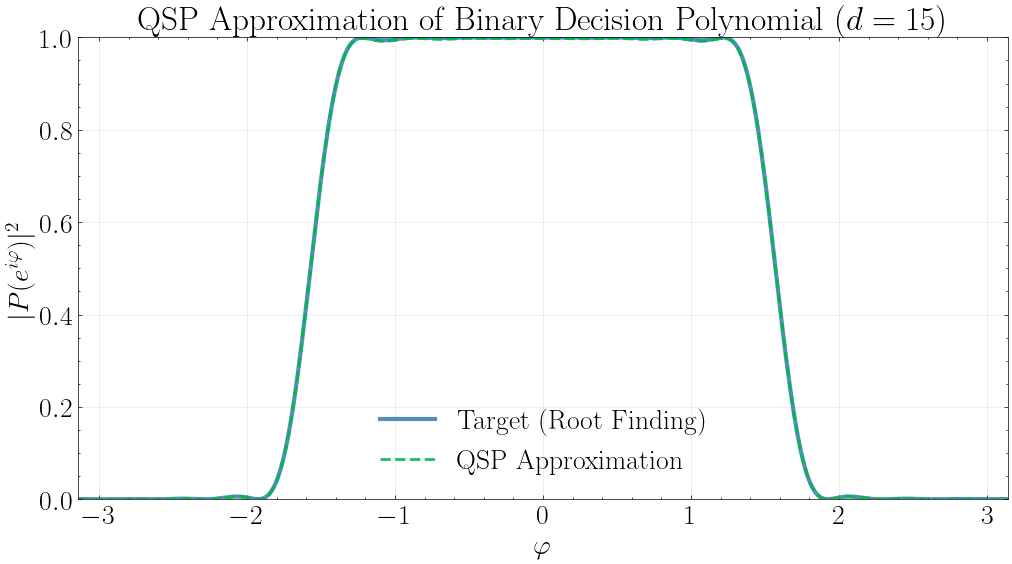

In [15]:
# Plot comparison: Target (root finding) vs QSP approximation
phi_plot = np.linspace(-np.pi, np.pi, 500)
z_plot = torch.tensor(np.exp(1j * phi_plot), dtype=torch.complex128)
targVals = targPoly(z_plot).cpu().numpy()
aprxVals = aprxPoly(z_plot)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(phi_plot, np.abs(targVals)**2, linewidth=3, label='Target (Root Finding)', alpha=0.7)
plt.plot(phi_plot, np.abs(aprxVals)**2, linewidth=2, linestyle='--', label='QSP Approximation', alpha=0.9)
plt.xlabel(r'$\varphi$')
plt.ylabel(r'$|P(e^{i\varphi})|^2$')
plt.title(f'QSP Approximation of Binary Decision Polynomial ($d={degQsp}$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-np.pi, np.pi)
plt.ylim(0, 1)
plt.show()